# Setup

In [2]:
cd /home/mitchellkwong/onedrive/workbins/BT4013/BT4013-toofdoctor

/home/mitchellkwong/onedrive/workbins/BT4013/BT4013-toofdoctor


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import datetime
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from tqdm.notebook import tqdm

import utils

# Model Tuning

In [4]:
from models.numeric.arima import Arima
from utils import load_futures_data, linearize, detrend

# Load and preprocess data
data = load_futures_data()
for future in data:
    data[future] = linearize(data[future], old_var='CLOSE', new_var='CLOSE_LINEAR')
    data[future] = detrend(data[future], old_var='CLOSE_LINEAR', new_var='CLOSE_VELOCITY')
    data[future] = detrend(data[future], old_var='CLOSE_VELOCITY', new_var='CLOSE_ACCELERATION')

# Fit models
candidates = [
    Arima('CLOSE_LINEAR'),
    Arima('CLOSE_VELOCITY'),
    Arima('CLOSE_ACCELERATION'),
]

dummy = pd.Series([0, 0, 0]) # Replace endog array to save space
for candidate in candidates:
    for future in tqdm(data):        
        # Load model
        try:
            with open(f'{candidate.SAVED_DIR}/{future}.p', 'rb') as f:
                model = pickle.load(f)
        
        # Or fit a new model if it doesn't exist
        except:
            model = Arima(y_var=candidate.y_var)
            model.fit(
                data, future,
                1, 1, 1,
                4, 2, 16,
                seasonal = False,
                suppress_warnings = True,
                error_action = 'ignore',
            )
            model._fit(dummy, None) # Drop endog array before saving
        
        # Save the model
        for forecast in ('price', 'returns', 'percent'):    
            model.SAVED_DIR = model.SAVED_DIR.replace(model.forecast, forecast)
            model.forecast = forecast
            
            root = Path(model.SAVED_DIR)
            root.mkdir(parents=True, exist_ok=True)
            p = root / f'{future}.p'
            with p.open('wb') as f:
                pickle.dump(model, f)       

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

# Load Models

In [38]:
records = []
for candidate in candidates:
    root = candidate.SAVED_DIR.replace(f'/{candidate.forecast}', '')
    for forecast in ('price', 'returns', 'percent'):    
        for future in data:
            with open(f'{root}/{forecast}/{future}.p', 'rb') as f:
                records.append({
                    'model': root.split('/')[-1],
                    'forecast': forecast,
                    'future': future,
                    'arima': pickle.load(f),
                })

models = pd.DataFrame.from_records(records)
models = models.set_index(['model', 'forecast', 'future'])
models['name'] = models['arima'].apply(lambda x: str(x.model))
models.head()

arima  \
model        forecast future                                                      
CLOSE_LINEAR price    F_AD    <models.numeric.arima.Arima object at 0x7fbfae...   
                      F_BO    <models.numeric.arima.Arima object at 0x7fbfae...   
                      F_BP    <models.numeric.arima.Arima object at 0x7fbfad...   
                      F_C     <models.numeric.arima.Arima object at 0x7fbfad...   
                      F_CC    <models.numeric.arima.Arima object at 0x7fbfae...   

                                                           name  
model        forecast future                                     
CLOSE_LINEAR price    F_AD     ARIMA(1,1,1)(0,0,0)[0]            
                      F_BO     ARIMA(0,1,0)(0,0,0)[0]            
                      F_BP     ARIMA(0,1,0)(0,0,0)[0]            
                      F_C      ARIMA(0,1,2)(0,0,0)[0]            
                      F_CC     ARIMA(0,1,0)(0,0,0)[0]

# Model Predictions

In [7]:
from models.numeric.model_validation import walk_forward

root = Path('model_predictions/numeric/arima')
root.mkdir(parents=True, exist_ok=True)
arima = models['arima']
    
for future in tqdm(utils.futuresList):
    p = root / f'{future}.csv'
    if not p.exists():
        windows, y_preds = walk_forward(
            model = arima['CLOSE_LINEAR', 'price', future].model,
            data = data[future]['CLOSE_LINEAR'],
            progress_bar = 'notebook',
        )
        y_preds.to_csv(p)

  0%|          | 0/88 [00:00<?, ?it/s]

TypeError: walk_forward() missing 1 required positional argument: 'future'

# Load Predictions

In [54]:
def normalized_MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) / y_true.std()

def normalized_RMSE(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred))) / y_true.std()

def load_predictions(path='model_predictions/numeric/arima/'):
    """Loads predictions in similar form as standardized data"""
    root = Path(path)
    subdirs = [subdir for subdir in root.glob('*/') if subdir.is_dir()]
    results = dict()
    for future in utils.futuresList:
        y_preds = list()
        for subdir in subdirs:
            y_pred = pd.read_csv(subdir / f'{future}.csv', index_col=0)
            y_pred.columns = [subdir.name]
            y_pred.index = pd.to_datetime(y_pred.index)
            y_preds.append(y_pred)
        y_preds = pd.concat(y_preds, axis=1)
        y_preds = y_preds[y_preds.notna().any(axis=1)]
        results[future] = y_preds
    return results

y_preds = load_predictions()
y_preds.keys()

dict_keys(['F_AD', 'F_BO', 'F_BP', 'F_C', 'F_CC', 'F_CD', 'F_CL', 'F_CT', 'F_DX', 'F_EC', 'F_ED', 'F_ES', 'F_FC', 'F_FV', 'F_GC', 'F_HG', 'F_HO', 'F_JY', 'F_KC', 'F_LB', 'F_LC', 'F_LN', 'F_MD', 'F_MP', 'F_NG', 'F_NQ', 'F_NR', 'F_O', 'F_OJ', 'F_PA', 'F_PL', 'F_RB', 'F_RU', 'F_S', 'F_SB', 'F_SF', 'F_SI', 'F_SM', 'F_TU', 'F_TY', 'F_US', 'F_W', 'F_XX', 'F_YM', 'F_AX', 'F_CA', 'F_DT', 'F_UB', 'F_UZ', 'F_GS', 'F_LX', 'F_SS', 'F_DL', 'F_ZQ', 'F_VX', 'F_AE', 'F_BG', 'F_BC', 'F_LU', 'F_DM', 'F_AH', 'F_CF', 'F_DZ', 'F_FB', 'F_FL', 'F_FM', 'F_FP', 'F_FY', 'F_GX', 'F_HP', 'F_LR', 'F_LQ', 'F_ND', 'F_NY', 'F_PQ', 'F_RR', 'F_RF', 'F_RP', 'F_RY', 'F_SH', 'F_SX', 'F_TR', 'F_EB', 'F_VF', 'F_VT', 'F_VW', 'F_GD', 'F_F'])

In [135]:
scores = list()
for future in utils.futuresList:
    for y_var in y_preds[future].columns:
        y_pred = y_preds[future][y_var]
        y_true = data[future][y_var]
        y_true = y_true[y_pred.index]
        scores.append({
            'future': future,
            'y_var': y_var,
            'ACC': np.mean(np.sign(y_true) == np.sign(y_pred)),
            'COST': utils.opportunity_cost(np.sign(data[future].loc[y_pred.index, 'CLOSE']), np.sign(y_pred), data[future].loc[y_pred.index, 'CLOSE']),
            'MAE': normalized_MAE(y_true, y_pred),
            'RMSE': normalized_RMSE(y_true, y_pred),
        })
scores = pd.DataFrame.from_records(scores).set_index(['future', 'y_var'])
scores.to_csv('model_metrics/arima_summary.csv')

In [138]:
scores.groupby('future').min()

ACC          COST       MAE      RMSE
future                                            
F_AD    0.480426  7.530000e+04  0.031252  0.044327
F_AE    0.008088  1.116100e+05  0.036159  0.055015
F_AH    0.466816  8.568000e+04  0.027897  0.040004
F_AX    0.504454  1.093800e+06  0.025344  0.037433
F_BC    0.502513  1.092100e+05  0.021598  0.030726
...          ...           ...       ...       ...
F_VX    0.496416  0.000000e+00  0.102657  0.151419
F_W     0.019359  0.000000e+00  0.040426  0.053924
F_XX    0.519367  2.831000e+04  0.055410  0.085400
F_YM    0.517382  1.328450e+05  0.021556  0.033206
F_ZQ    0.274774  1.954776e+08  0.006037  0.019634

[88 rows x 4 columns]

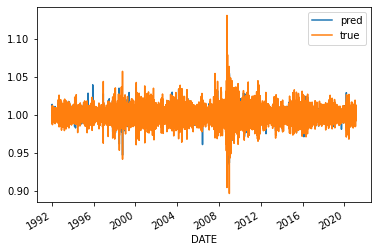

0.8665001387732445
0.7550652234249237


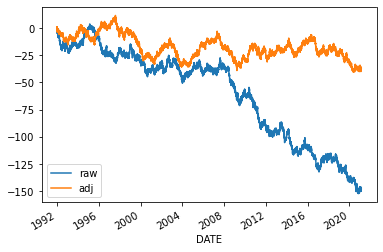

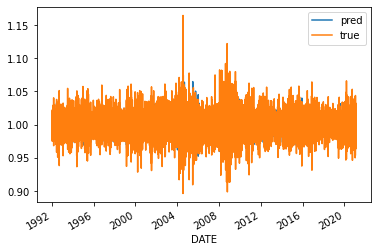

0.84683578832515
0.7206764866339335


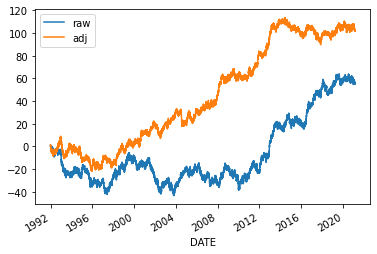

0.8604427333974976
0.7401347449470644


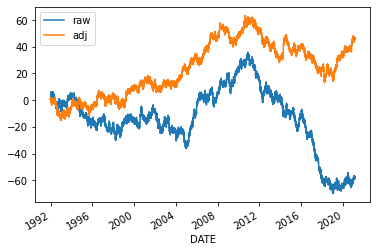

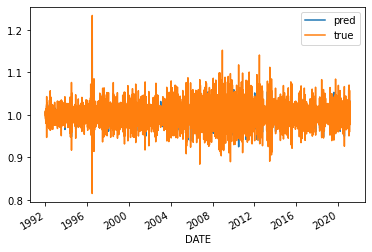

0.841717791411043
0.7127471029311521


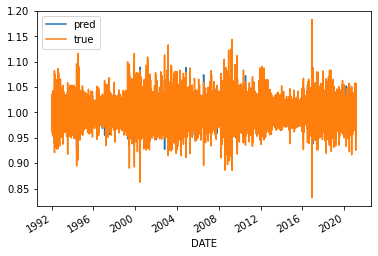

0.8460167283696696
0.7228849581790758


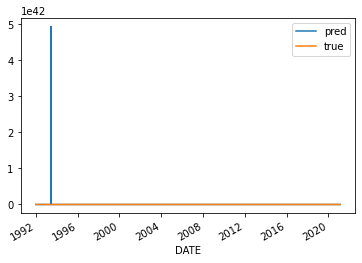

0.8562457337883959
0.731740614334471


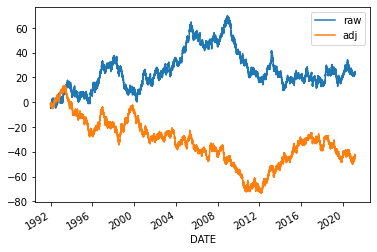

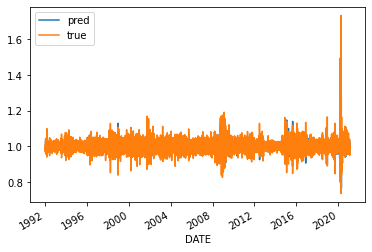

0.8525106033657135
0.7274592967574224


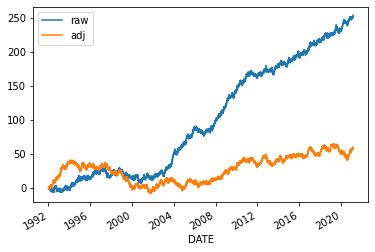

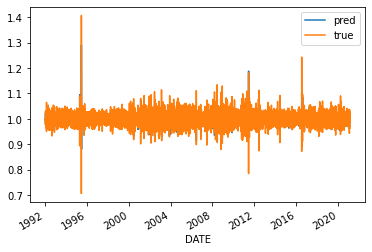

0.8355488556941209
0.7094696450596135


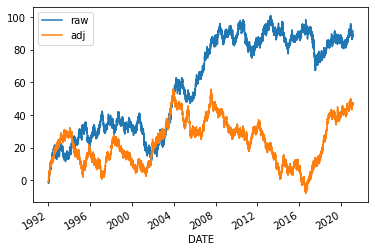

/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


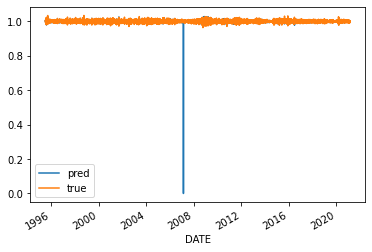

0.8659984579799538
0.7468003084040092


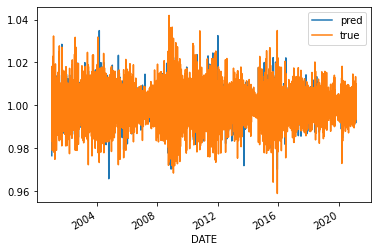

0.8654465004022526
0.7477876106194691


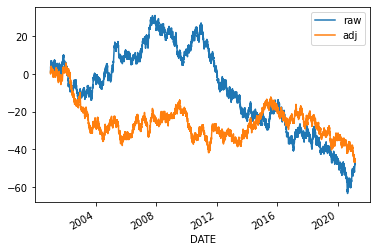

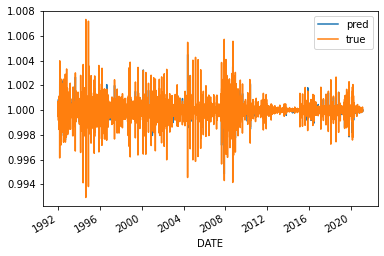

0.7880442200081889
0.6454210454483418


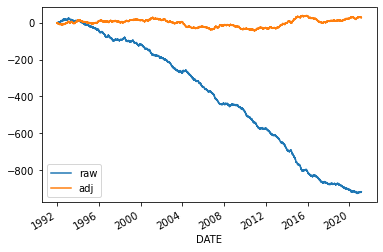

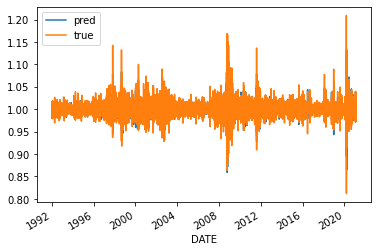

0.8700534027112146
0.760646309735725


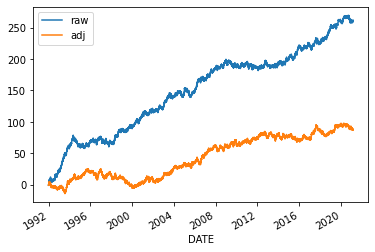

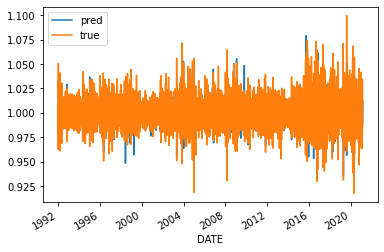

0.859073359073359
0.7351075565361279


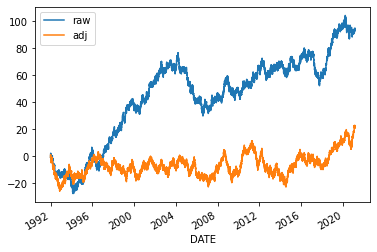

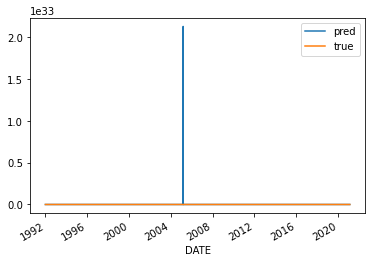

0.8573965305286163
0.7339161316760006


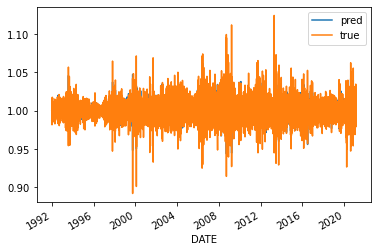

0.8544087491455913
0.7304169514695831


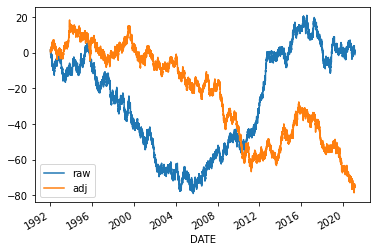

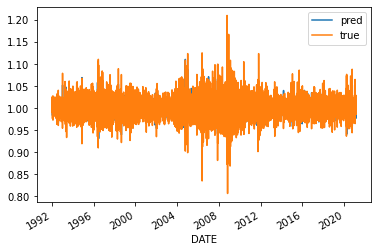

0.8572405305620129
0.7317106522630932


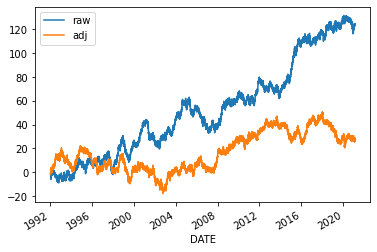

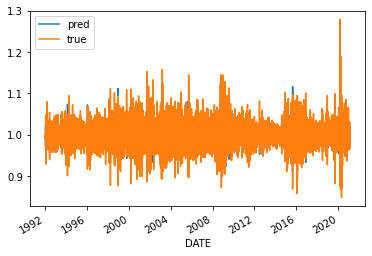

0.8507299768044754
0.7284759175876654


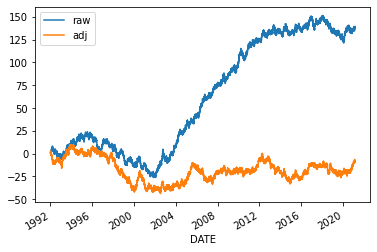

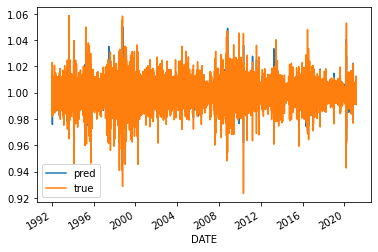

0.8557207145779354
0.7380335469794082


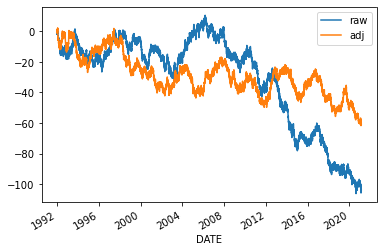

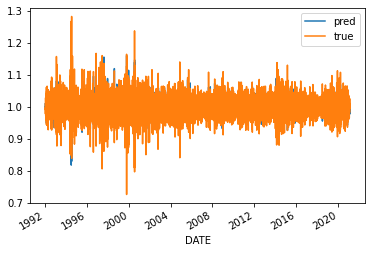

0.8399616017553483
0.7184585847504114


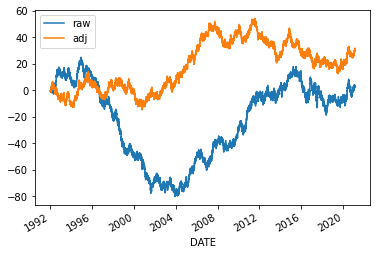

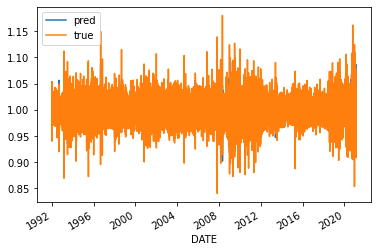

0.8440354464894342
0.7107021131561009


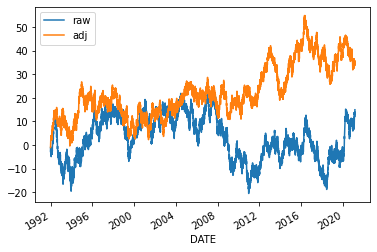

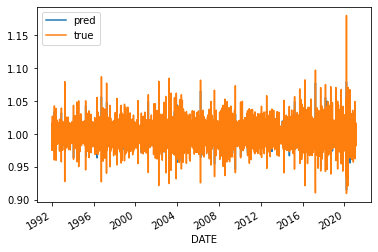

0.8460698689956332
0.7254366812227074


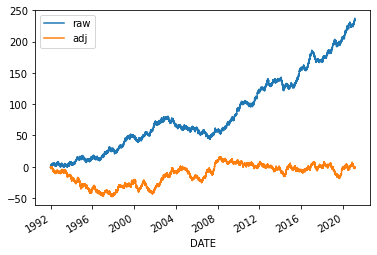

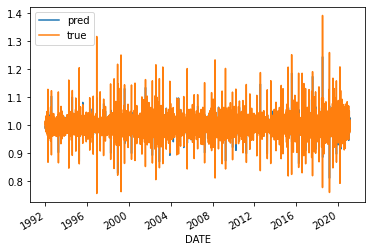

0.8445567545417293
0.7161589946728589


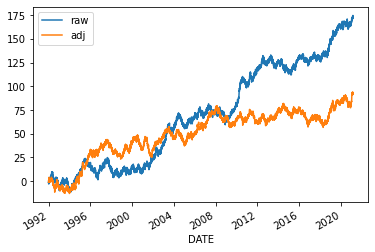

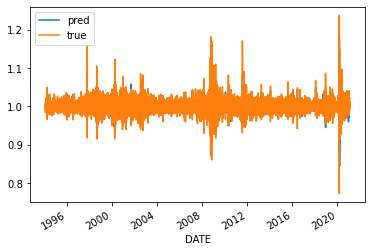

0.8678603137022788
0.7505179047055341


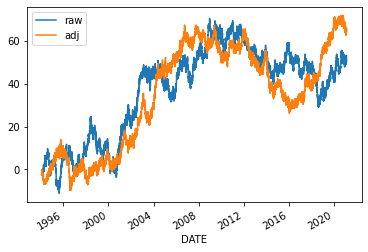

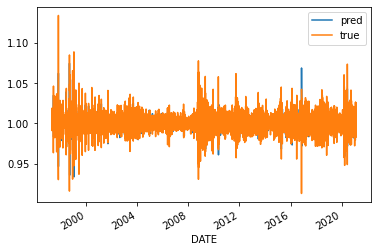

0.8466298712159224
0.7221943468807492


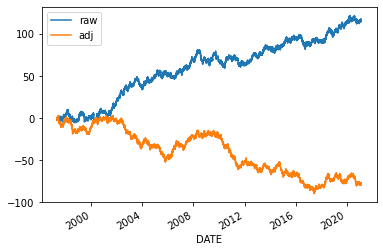

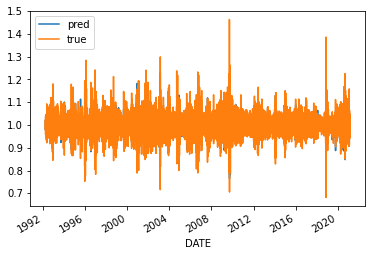

0.8497237569060774
0.7256906077348066


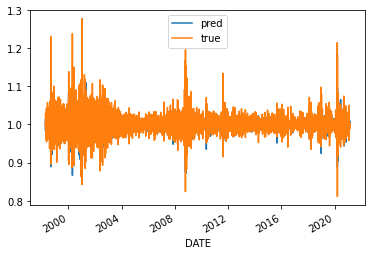

0.8525017373175816
0.73227936066713


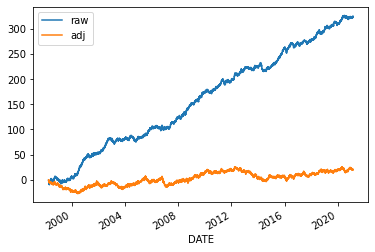

0.8371966184892282
0.7046632124352331


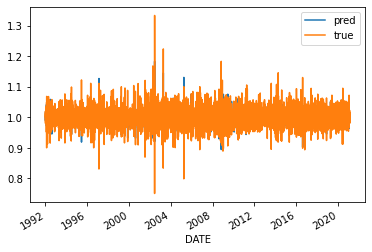

0.8307608250239038
0.6912990028684606


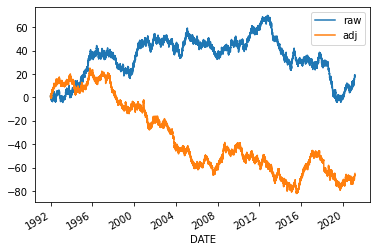

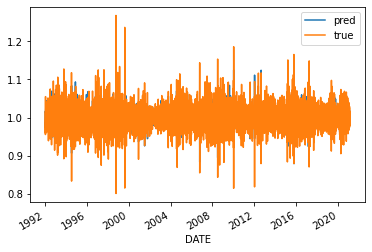

0.8312311488894982
0.7026323005209761


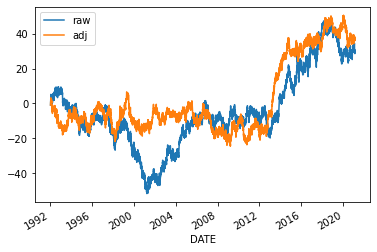

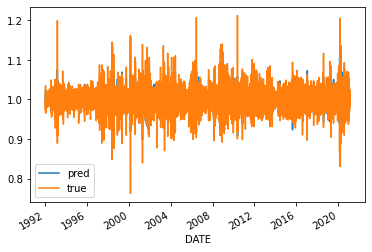

0.8346327451784982
0.701545616194775


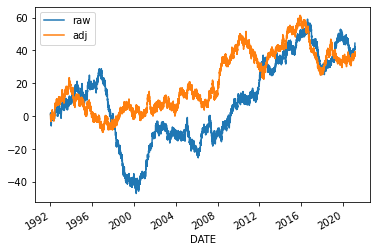

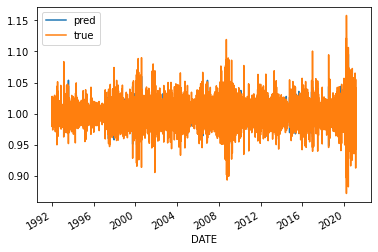

0.8469429626590069
0.7223362057174121


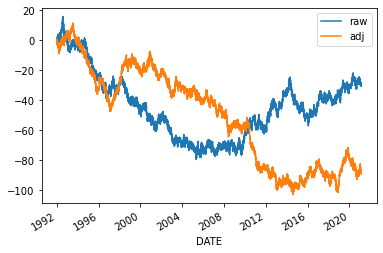

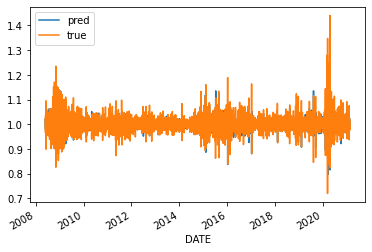

0.8424336973478939
0.7117004680187208


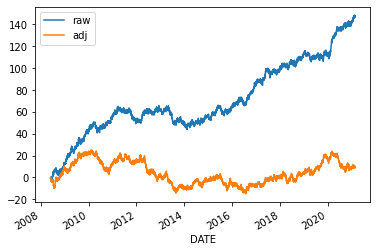

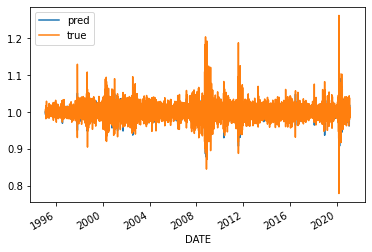

0.8520826999087868
0.7309212526603831


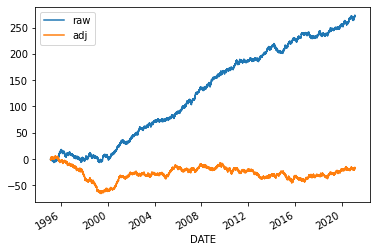

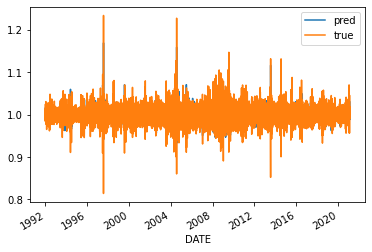

0.8550388654029729
0.7340788217646257


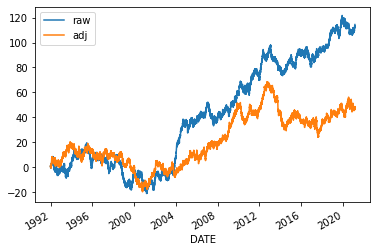

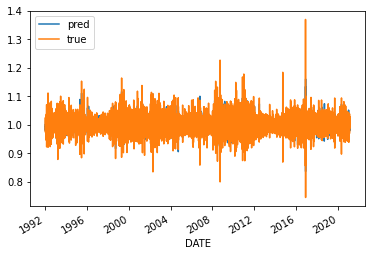

0.8386123680241327
0.7167146578911284


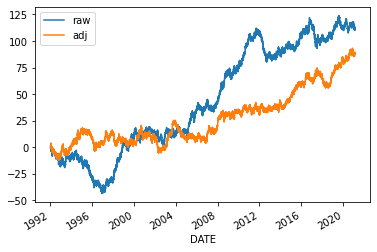

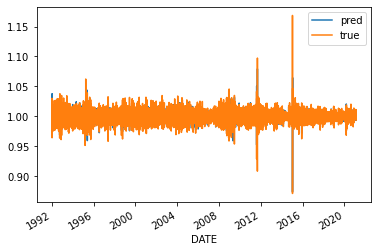

0.8716151202749141
0.7589003436426117


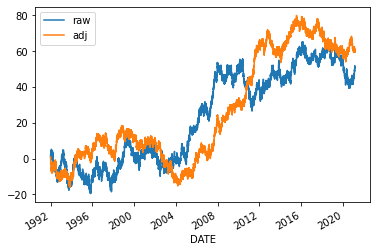

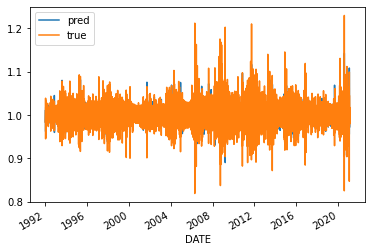

0.852044304662929
0.7256939696431013


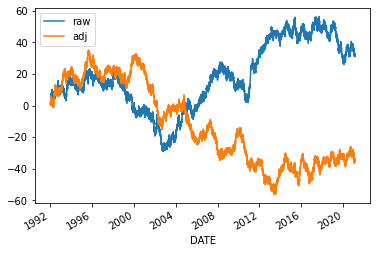

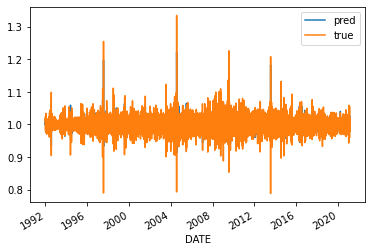

0.8440867548765516
0.7176374300913927


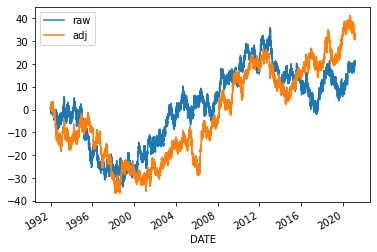

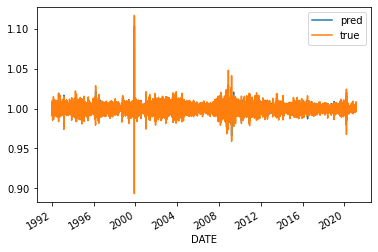

0.8591549295774648
0.7399152194721729


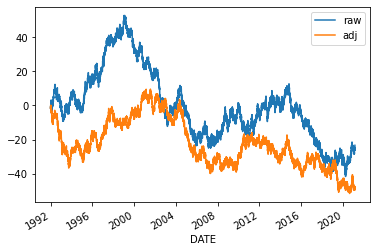

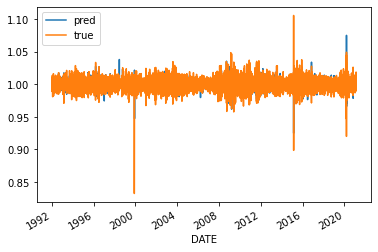

0.8616902974701139
0.7486794551014735


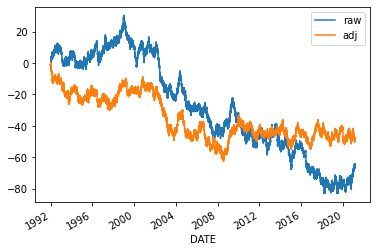

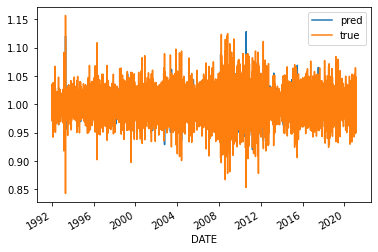

0.8502863376056722
0.7259340059994546


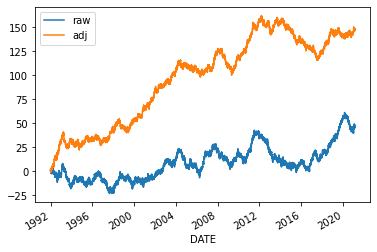

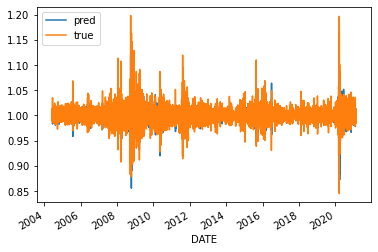

0.8561304039688165
0.7410819749586581


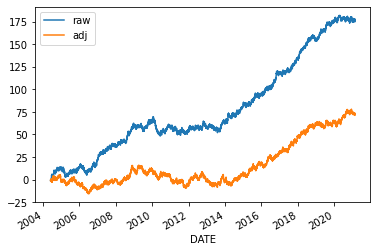

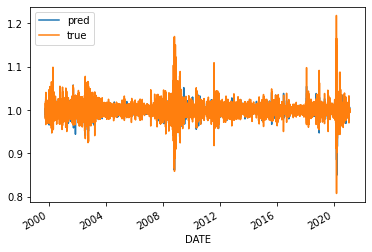

0.872917836421486
0.762680142242186


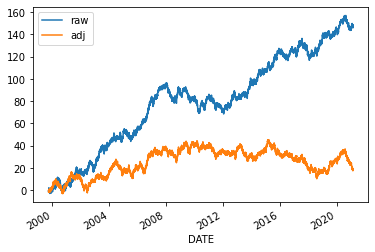

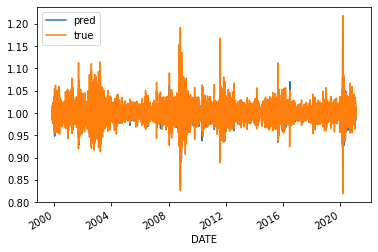

0.8617041024689066
0.7469834787451272


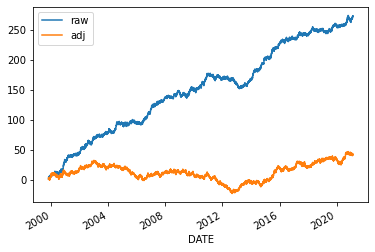

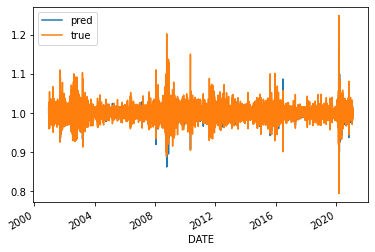

0.8546875
0.73125


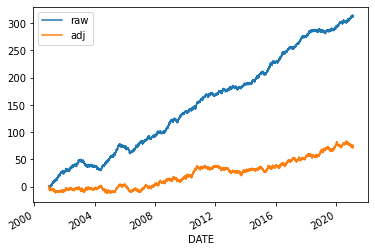

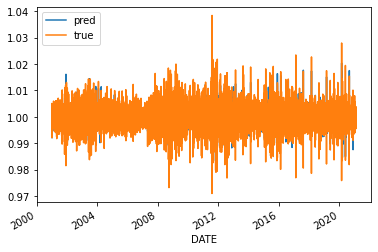

0.8657625786163522
0.7511792452830188


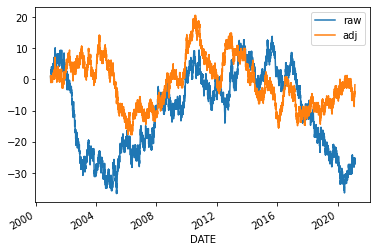

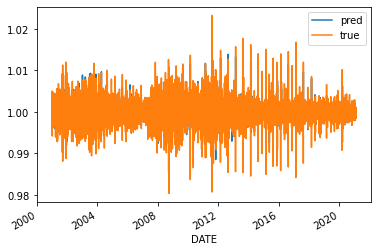

0.8595252109083775
0.7416127133608005


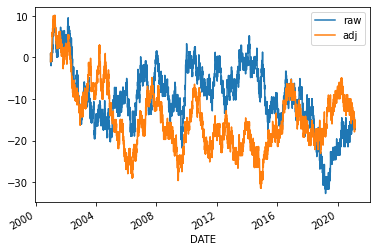

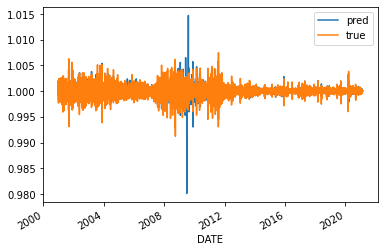

0.8429411764705882
0.7164705882352941


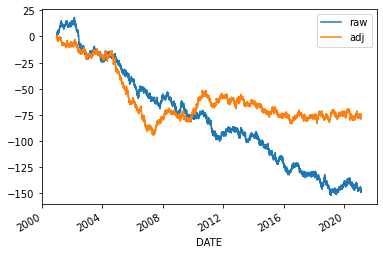

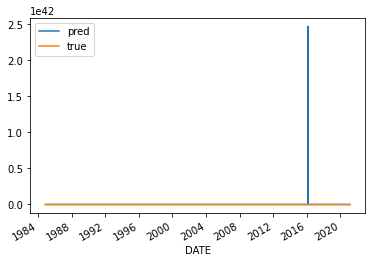

0.8593218479095798
0.741907165587622


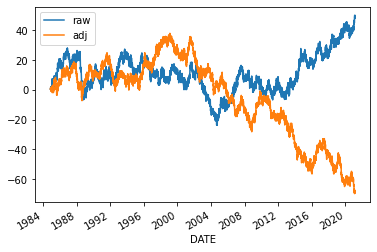

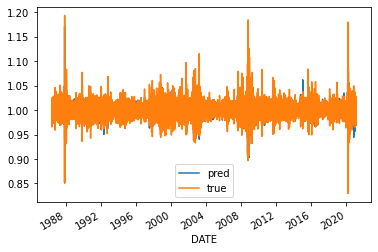

0.8654549611339735
0.7521719250114312


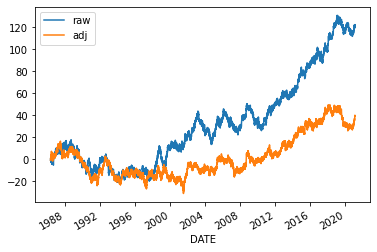

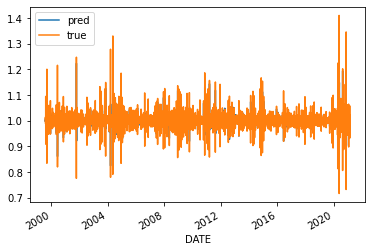

0.8226491779050434
0.6927766488084242


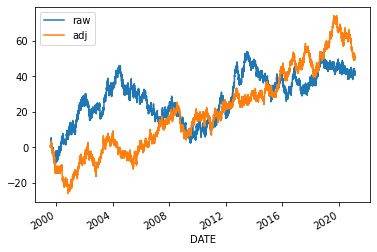

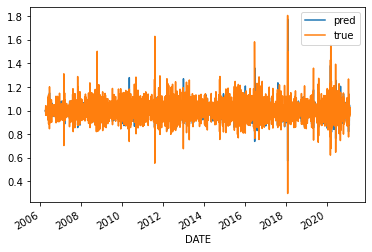

0.8475836431226765
0.7219861922464152


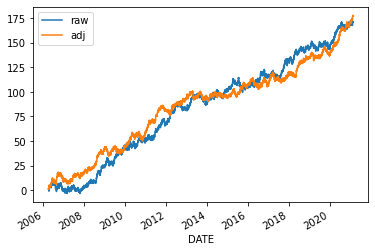

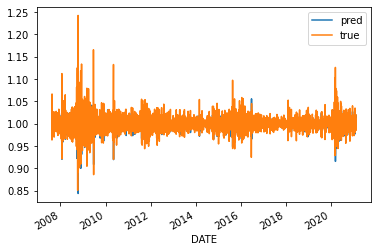

0.8428199942213234
0.7133776365212366


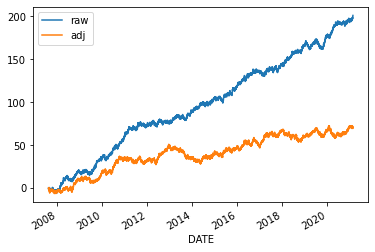

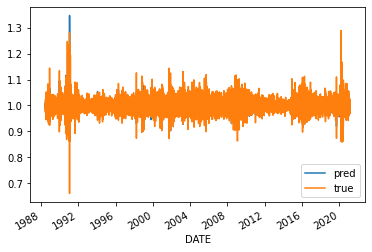

0.8482742090124641
0.7184803451581975


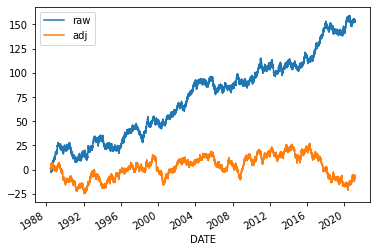

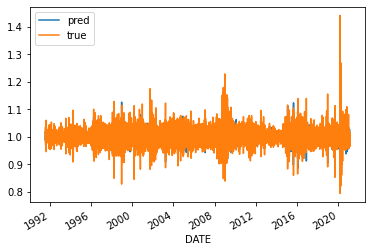

0.8489218150549015
0.7235084005820875


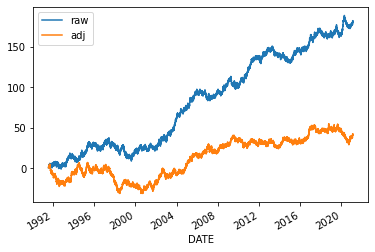

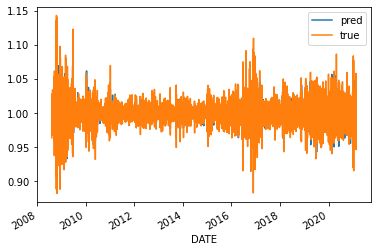

0.8352719270669601
0.7007230430682175


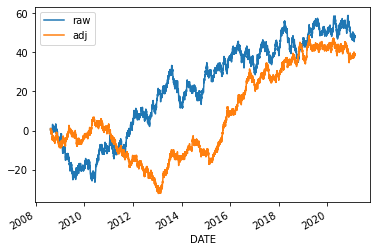

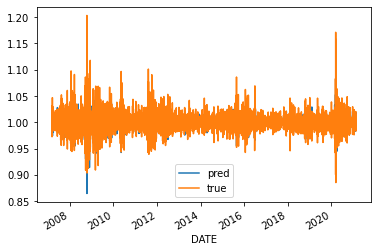

0.8521444695259593
0.7212189616252822


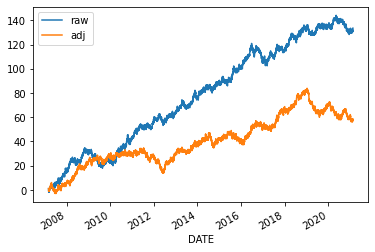

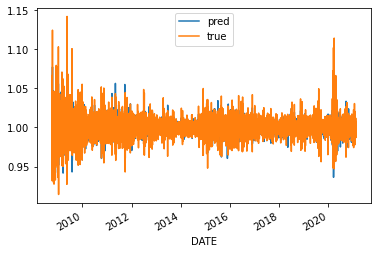

0.8611382113821138
0.7427642276422765


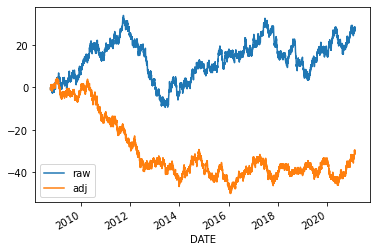

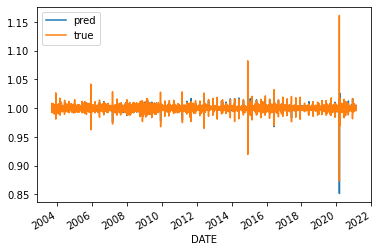

0.8593856655290102
0.7433447098976109


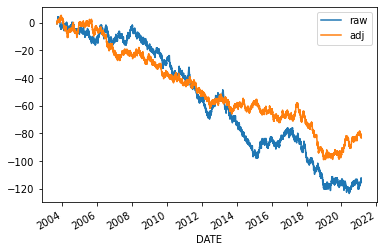

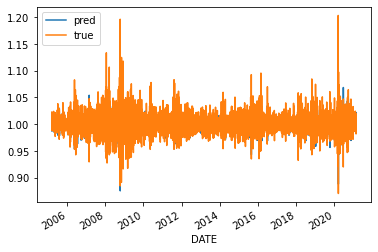

0.8552729068905903
0.7330204988886144


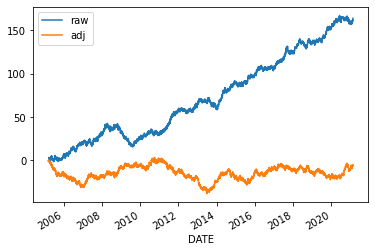

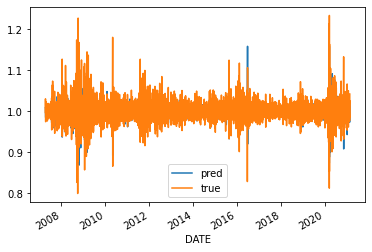

0.8524729960204662
0.7288231949971575


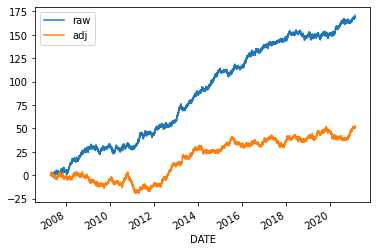

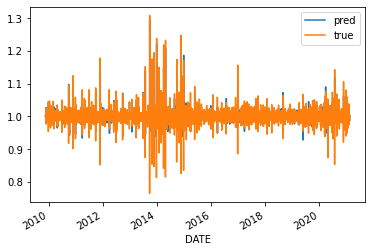

0.8250801567509797
0.694335589597435


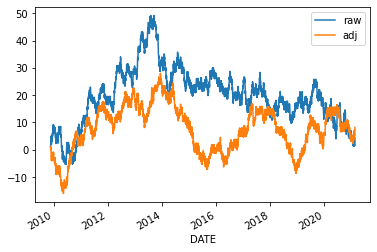

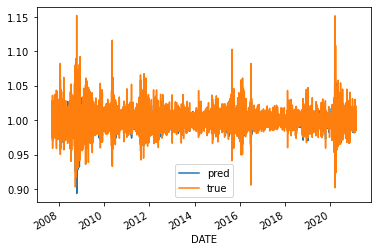

0.8473237788827143
0.7215560105293946


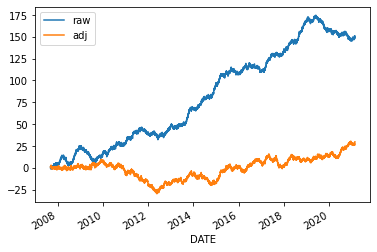

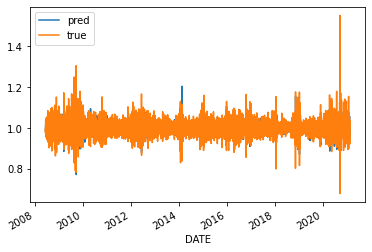

0.8529871754770098
0.7284954644979669


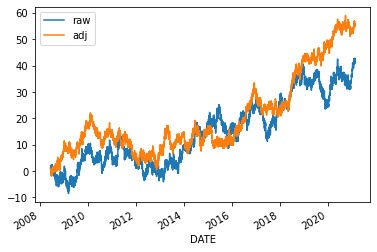

In [11]:
for future in y_preds.columns:
    y_pred = y_preds[future].dropna()
    y = data[future].loc[y_pred.index, 'CLOSE_ACCELERATION']
    
    y_pred = np.exp(y_pred)
    y = np.exp(y)
    
    y_pred.plot(label='pred')
    y.plot(label='true')
    plt.legend()
    plt.show()
    
    pos_pred = np.sign(y_pred - y.shift()).dropna()
    pos_true = np.sign(y.diff()).dropna()
    
    acc = pos_true == pos_pred
    adj = 2 * acc.shift().fillna(1) - 1
    
    print(np.mean(pos_pred == pos_true))    
    print(np.mean(pos_pred * adj == pos_true))
    
    (pos_pred * y).cumsum().plot(label='raw')
    (adj * pos_pred * y).cumsum().plot(label='adj')
    plt.legend()
    plt.show()

# Predict positions

In [73]:
from models.categorical.arima_ensemble import ArimaEnsemble

root = Path(ArimaEnsemble.SAVED_DIR)
root.mkdir(parents=True, exist_ok=True)

ensemble_models = pd.Series(np.nan, index=utils.futuresList, name='model')
for future in tqdm(ensemble_models.index):    
    path = root / f'{future}.p'
    try:
        raise
        with path.open('rb') as f:
            model = pickle.load(f)
    except:
        model = ArimaEnsemble(future=future)
        model.fit(data, future)
        with path.open('wb') as f:
            pickle.dump(model, f)
    ensemble_models[future] = model

ensemble_models

  0%|          | 0/88 [00:00<?, ?it/s]

F_AD    <models.categorical.arima_ensemble.ArimaEnsemb...
F_BO    <models.categorical.arima_ensemble.ArimaEnsemb...
F_BP    <models.categorical.arima_ensemble.ArimaEnsemb...
F_C     <models.categorical.arima_ensemble.ArimaEnsemb...
F_CC    <models.categorical.arima_ensemble.ArimaEnsemb...
                              ...                        
F_VF    <models.categorical.arima_ensemble.ArimaEnsemb...
F_VT    <models.categorical.arima_ensemble.ArimaEnsemb...
F_VW    <models.categorical.arima_ensemble.ArimaEnsemb...
F_GD    <models.categorical.arima_ensemble.ArimaEnsemb...
F_F     <models.categorical.arima_ensemble.ArimaEnsemb...
Name: model, Length: 88, dtype: object

In [55]:
import warnings
from xgboost import XGBClassifier

pos_models = dict()
for future in tqdm(utils.futuresList):
    X1 = data[future]
    X1 = X1[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']]

    X2 = y_preds[future]
    X2 = X2.shift(-1) # Predictions made AT each date (instead of predictions FOR each date)

    labels = data[future]['CLOSE']
    labels = labels.diff().shift(-1)
    labels = np.sign(labels.dropna())
    labels.name = 'label'

    features = pd.concat([X1, X2, labels], axis=1)
    features = features.dropna()

    y = 'label'
    X = features.columns.drop(y)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        bst = XGBClassifier(n_jobs=8, eval_metric='mlogloss')
        bst = bst.fit(
            features[X], features[y],
            eval_set = [(features[X], features[y])],
            verbose = False,
        )
    pos_models[future] = bst

  0%|          | 0/88 [00:00<?, ?it/s]

In [69]:
acc = dict()
for future in tqdm(utils.futuresList):
    X1 = data[future]
    X1 = X1[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']]

    X2 = y_preds[future]
    X2 = X2.shift(-1) # Predictions made AT each date (instead of predictions FOR each date)

    labels = data[future]['CLOSE']
    labels = labels.diff().shift(-1)
    labels = np.sign(labels.dropna())
    labels.name = 'label'

    features = pd.concat([X1, X2, labels], axis=1)
    features = features.dropna()

    y = 'label'
    X = features.columns.drop(y)
    
    acc[future] = pos_models[future].score(features[X], features[y])

acc

  0%|          | 0/88 [00:00<?, ?it/s]

{'F_AD': 0.9206106870229007,
 'F_BO': 0.9013507981989357,
 'F_BP': 0.9091659785301404,
 'F_C': 0.89207258834766,
 'F_CC': 0.8806911684037301,
 'F_CD': 0.8861710849959005,
 'F_CL': 0.9003831417624522,
 'F_CT': 0.9199012481141133,
 'F_DX': 0.9205614684559618,
 'F_EC': 0.9339242546333602,
 'F_ED': 0.8467514124293786,
 'F_ES': 0.8975202082477052,
 'F_FC': 0.9032836644591612,
 'F_FV': 0.9071135430916553,
 'F_GC': 0.9054978118161926,
 'F_HG': 0.9115795236791678,
 'F_HO': 0.8890708145722472,
 'F_JY': 0.9075034106412005,
 'F_KC': 0.9197750959956116,
 'F_LB': 0.9274413529732679,
 'F_LC': 0.9031288427380789,
 'F_LN': 0.9154487091927332,
 'F_MD': 0.897690257625111,
 'F_MP': 0.9009370816599732,
 'F_NG': 0.9128453038674034,
 'F_NQ': 0.9258036490008688,
 'F_NR': 0.8926330150068212,
 'F_O': 0.9003145084096814,
 'F_OJ': 0.9154099259665478,
 'F_PA': 0.9036803940347516,
 'F_PL': 0.9164726824592633,
 'F_RB': 0.9819032761310452,
 'F_RU': 0.9132684114424833,
 'F_S': 0.8844947497613528,
 'F_SB': 0.901906983

In [72]:
pd.DataFrame(
    data = [pos_models[future].feature_importances_ for future in tqdm(utils.futuresList)],
    columns = X,
)

  0%|          | 0/88 [00:00<?, ?it/s]

OPEN      HIGH       LOW     CLOSE       VOL  CLOSE_ACCELERATION  \
0   0.110861  0.128947  0.129725  0.126928  0.113563            0.120559   
1   0.128659  0.158173  0.155435  0.147987  0.134382            0.139393   
2   0.133838  0.154844  0.152654  0.156955  0.130836            0.137180   
3   0.109834  0.134303  0.140304  0.131700  0.120157            0.110676   
4   0.137797  0.157040  0.198156  0.213043  0.150939            0.143024   
..       ...       ...       ...       ...       ...                 ...   
83  0.116400  0.130958  0.127028  0.143911  0.116008            0.118520   
84  0.108701  0.135011  0.138737  0.149888  0.125091            0.112391   
85  0.115994  0.119058  0.149176  0.137614  0.116429            0.111479   
86  0.114343  0.128293  0.133545  0.137712  0.113843            0.116859   
87  0.117133  0.128323  0.165083  0.154409  0.102992            0.096099   

    CLOSE_LINEAR  CLOSE_VELOCITY  
0       0.151771        0.117645  
1       0.000000        0.135970  
2       0.000000        0.133693  
3       0.136247        0.116778  
4       0.000000        0.000000  
..           ...             ...  
83      0.126381        0.120794  
84      0.115789        0.114392  
85      0.133865        0.116385  
86      0.135438        0.119968  
87      0.145812        0.090151  

[88 rows x 8 columns]

In [78]:
X1 = data[future]
X1 = X1[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']]

X2 = y_preds[future]
X2 = X2.shift(-1) # Predictions made AT each date (instead of predictions FOR each date)

labels = data[future]['CLOSE']
labels = labels.diff()
labels = np.sign(labels.dropna())
labels.name = 'label'

features = pd.concat([X1, X2, labels], axis=1)
features = features.dropna()
features

y = 'label'
X = features.columns.drop(y)
dataset = xgb.DMatrix(features[X], label=features[y])

# Stuff

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4893.681, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4903.515, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4901.521, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4901.512, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4904.834, Time=0.04 sec


  2%|▏         | 2/100 [00:00<00:05, 17.57it/s]

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4899.220, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.900 seconds


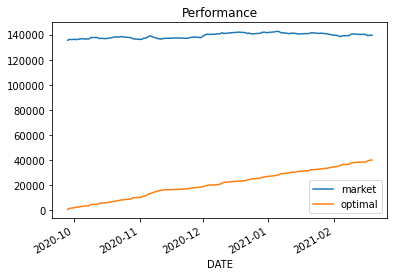

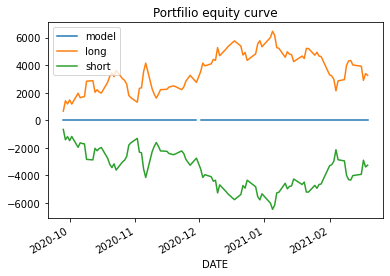

F_SF
Accuracy: 0.010101010101010102


In [164]:
sample_future = np.random.choice(utils.futuresList)
sample_data = data[sample_future]['CLOSE_LINEAR'].tail(604)
sample_model = pm.auto_arima(sample_data, seasonality=False, trace=True)

windows, y_preds = walk_forward(
    model = sample_model,
    data = sample_data,
    progress_bar = True,
)

y = np.exp(sample_data) - np.exp(sample_data.shift())
y_pred = np.exp(y_preds) - np.exp(sample_data.shift())

# Model equity curve
returns = np.sign(y_pred) * y
equity = returns.cumsum()

# Benchmarks
mask = equity.dropna().index
optimal = y[mask].abs().cumsum()
long = y[mask].cumsum()
short = -y[mask].cumsum()

np.exp(sample_data[mask]).plot(label='market')
optimal.plot(label='optimal')
plt.title('Performance')
plt.legend()
plt.show()

equity.plot(label='model')
long.plot(label='long')
short.plot(label='short')
plt.title('Portfilio equity curve')
plt.legend()
plt.show()

print(sample_future)
print('Accuracy:', np.mean(np.sign(y_pred[mask]) == np.sign(y[mask])))

# Why is R so fast???

# Data Exploration

In [4]:
data = utils.load_futures_data()

In [53]:
?fit

In [70]:
transformations = {
    'raw': lambda x: x,
    'linearize': lambda x: np.log(x),
    'detrend': lambda x: np.diff(x),
    'linearize_detrend': lambda x: np.diff(np.log(x)),
}

metrics = {
    'rsquared': lambda fit: fit.rsquared,
    'pvalue': lambda fit: fit.pvalues[1], 
}

results = pd.DataFrame(
    index = pd.MultiIndex.from_product([utils.futuresList, transformations], names=['future', 'transformation']),
    columns = metrics,
)

for future, name in tqdm(results.index):
    f = transformations[name]
    y = f(data[future]['CLOSE'])
    X = sm.add_constant(np.arange(len(y)))
    fit = sm.OLS(y, X).fit()
    
    for metric, func in metrics.items():
        results.loc[(future, name), metric] = func(fit)

results.head()

100%|██████████| 352/352 [00:00<00:00, 520.01it/s]


rsquared    pvalue
future transformation                       
F_AD   raw                0.100188       0.0
       linearize          0.093799       0.0
       detrend            0.000003  0.882197
       linearize_detrend  0.000006  0.827577
F_BO   raw                0.300287       0.0

In [87]:
import matplotlib.pyplot as plt
from pmdarima.arima import ADFTest, KPSSTest

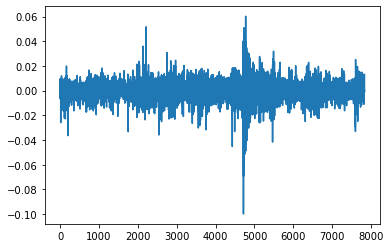

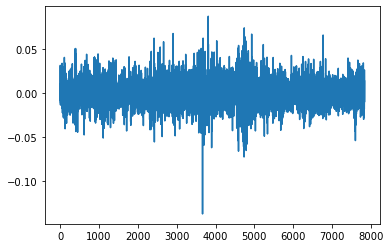

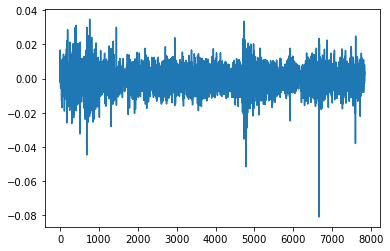

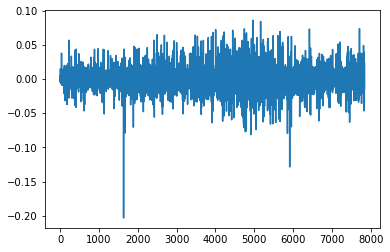

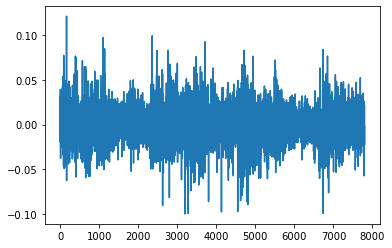

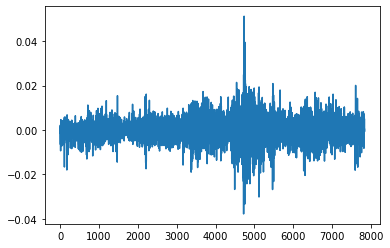

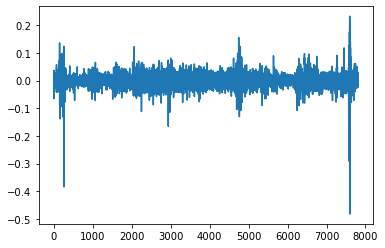

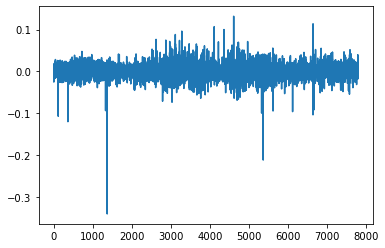

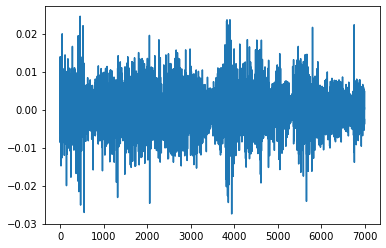

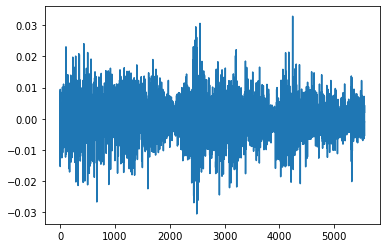

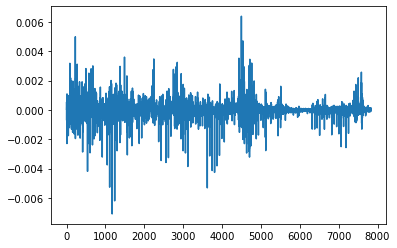

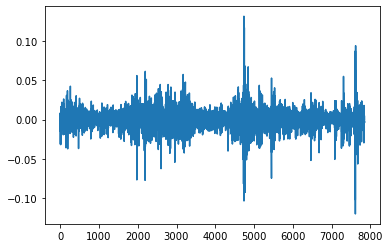

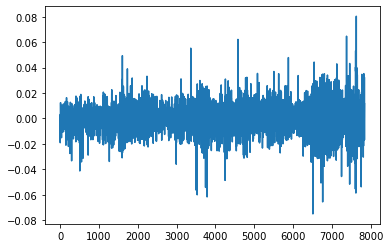

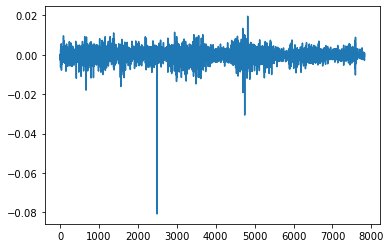

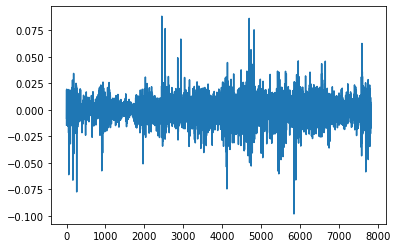

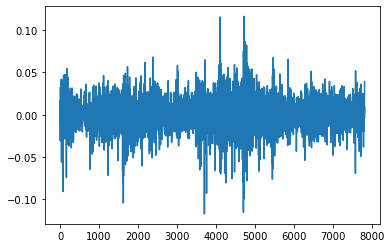

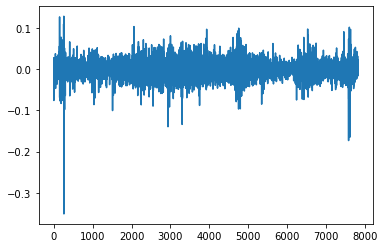

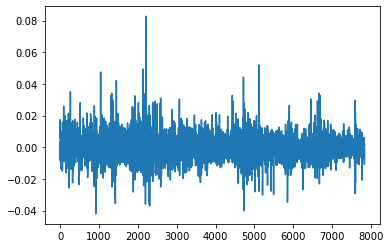

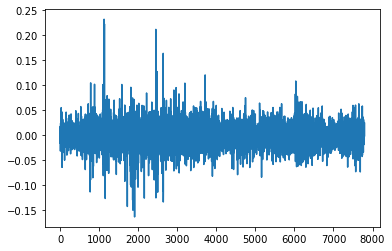

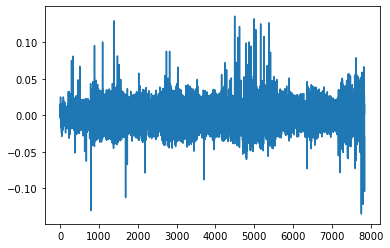

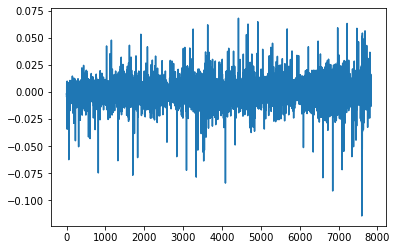

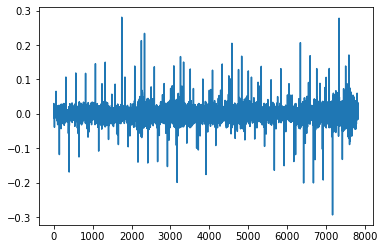

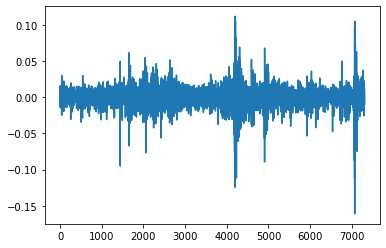

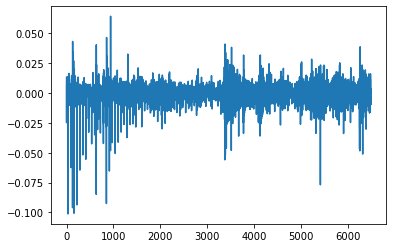

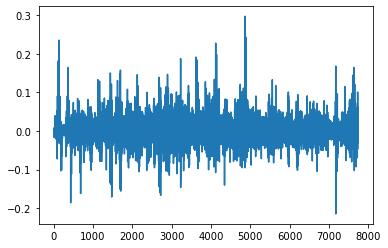

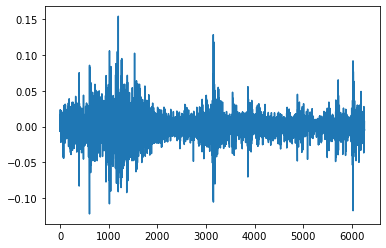

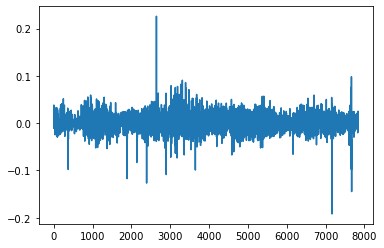

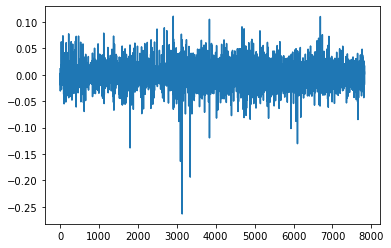

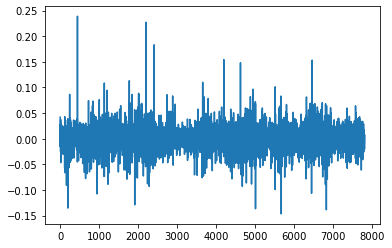

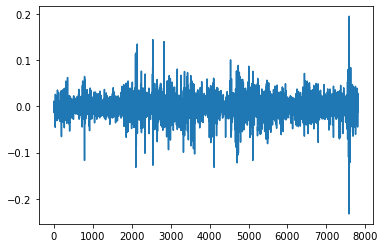

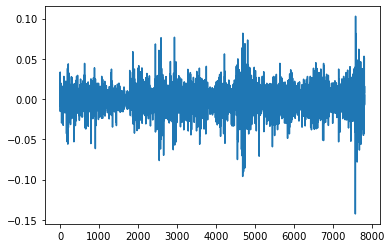

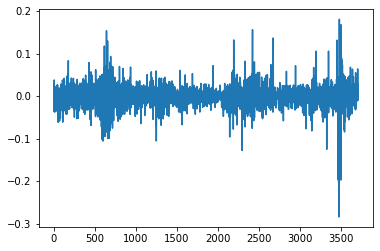

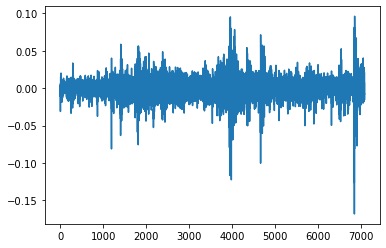

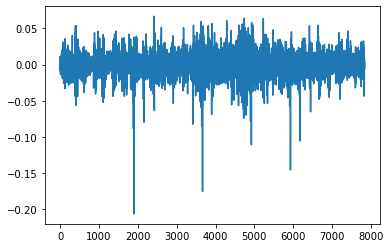

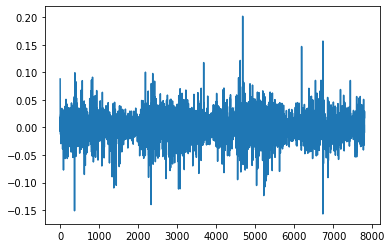

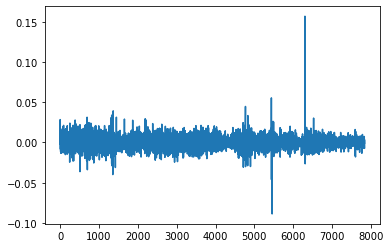

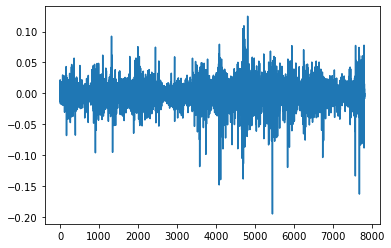

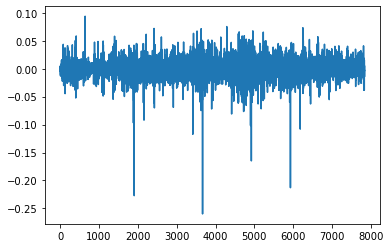

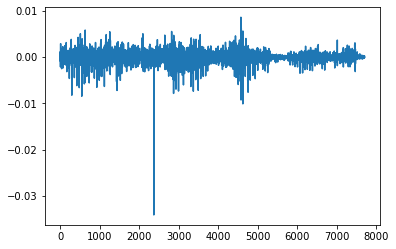

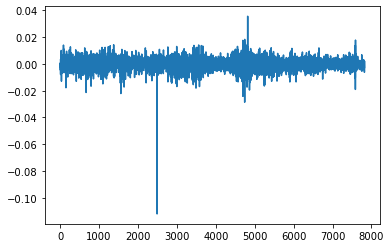

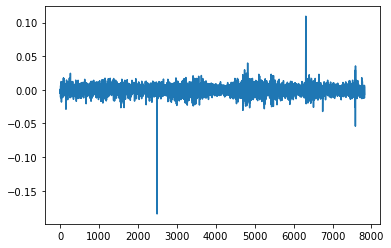

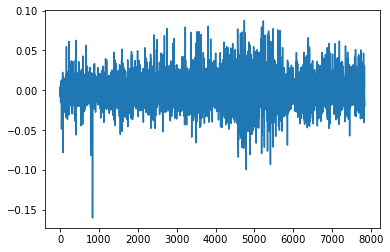

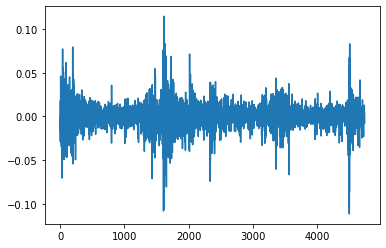

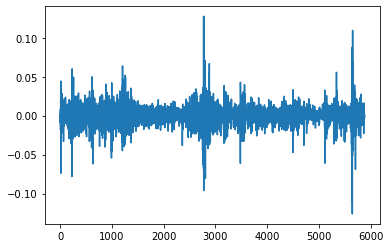

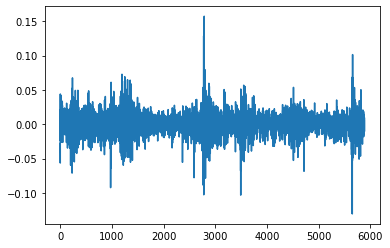

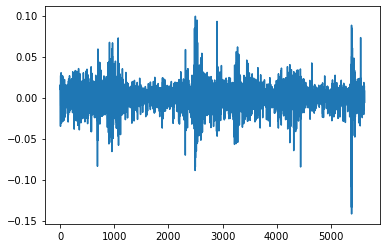

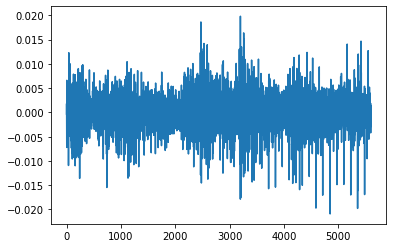

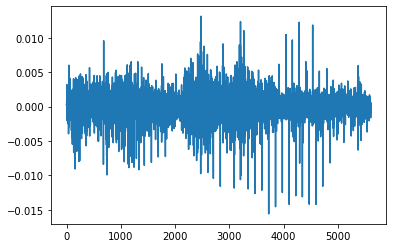

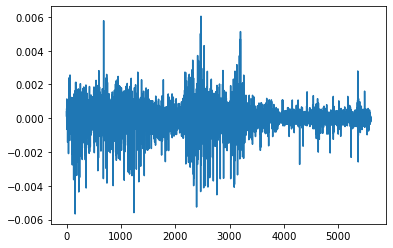

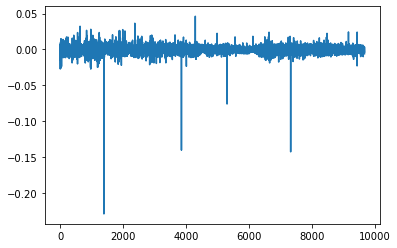

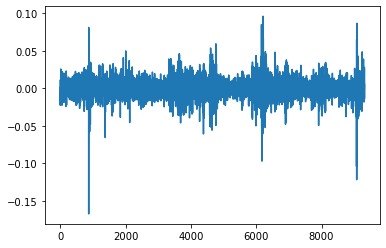

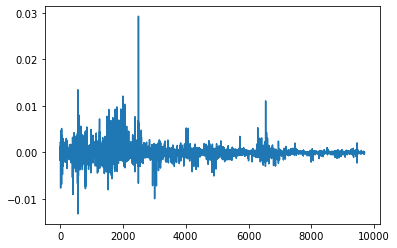

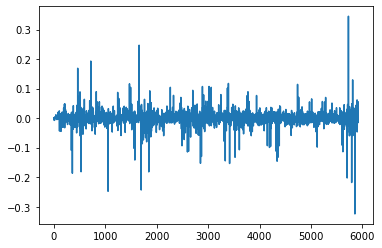

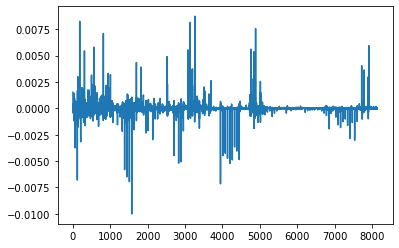

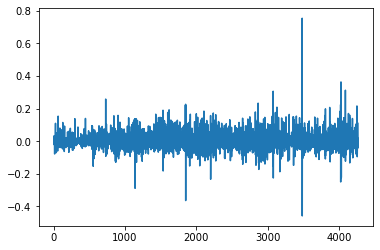

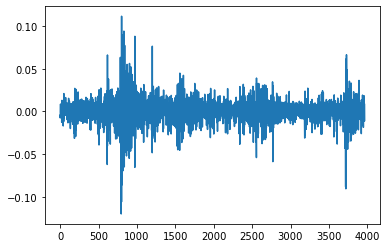

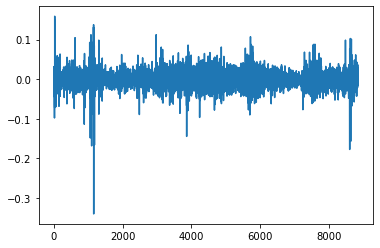

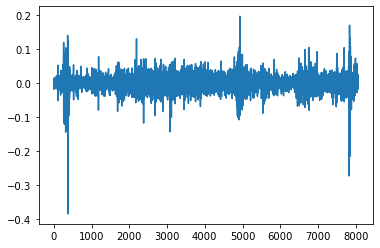

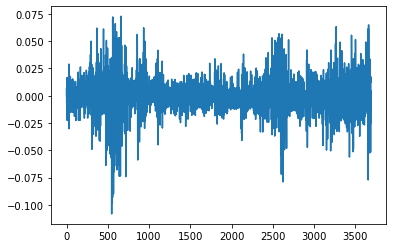

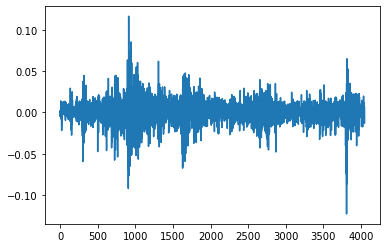

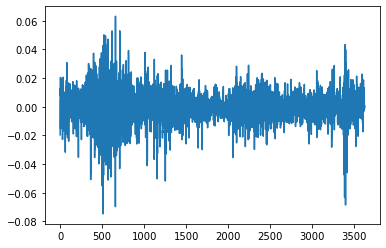

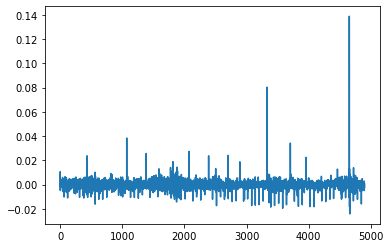

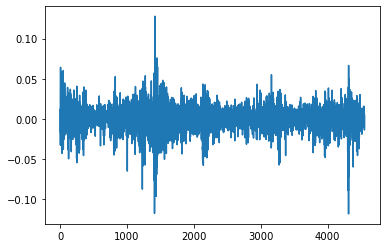

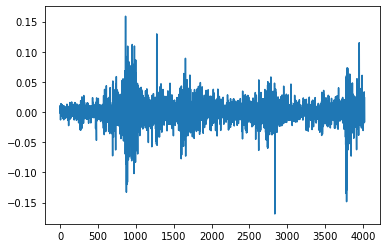

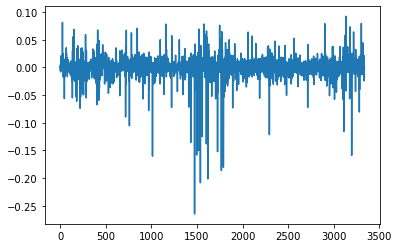

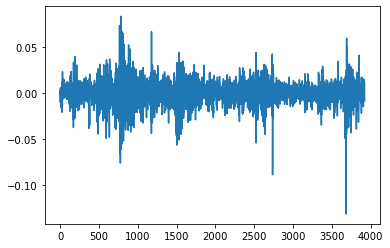

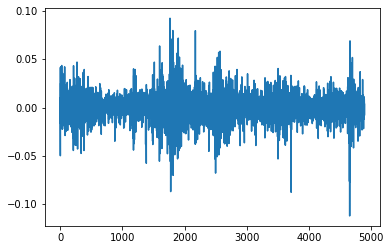

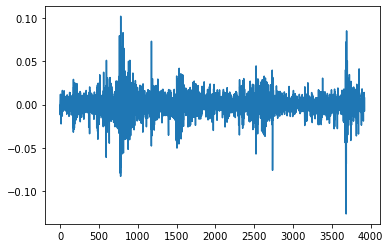

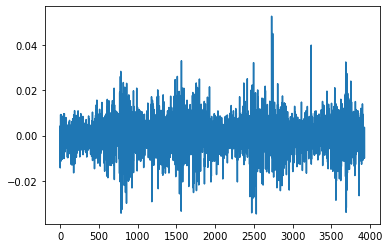

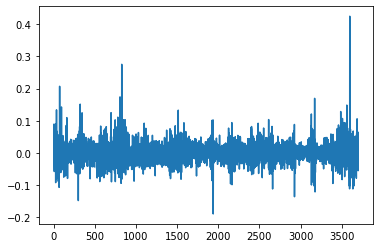

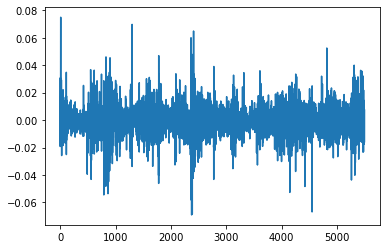

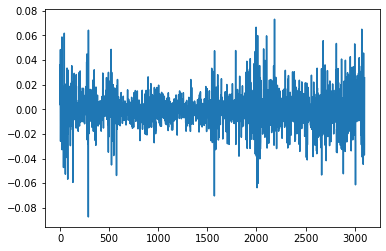

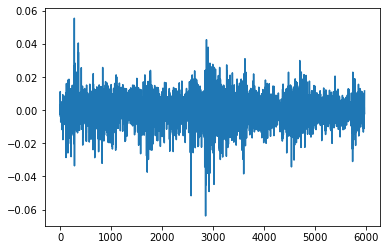

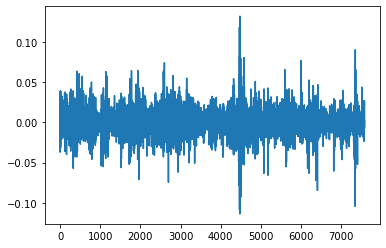

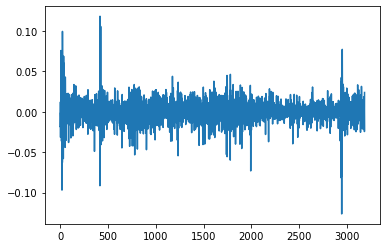

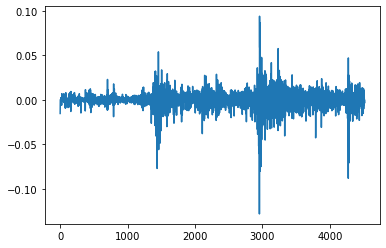

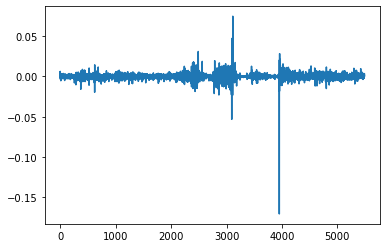

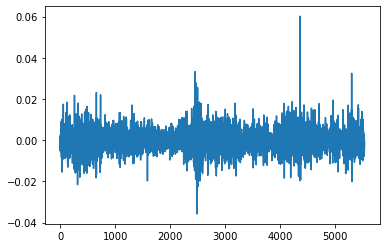

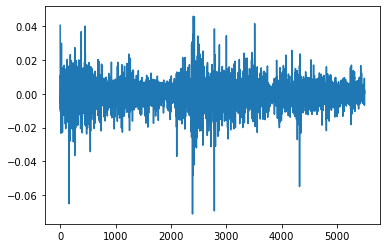

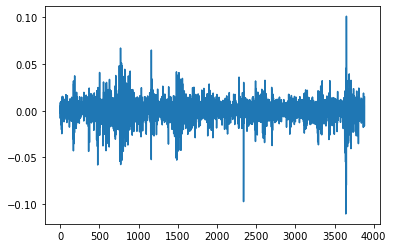

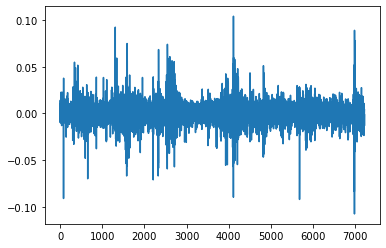

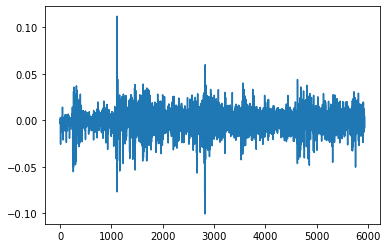

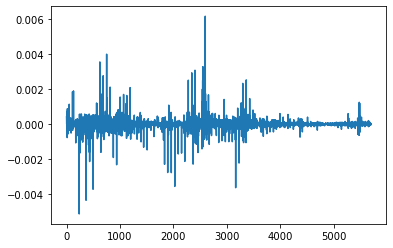

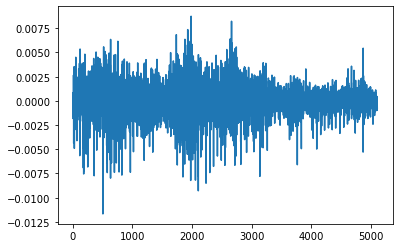

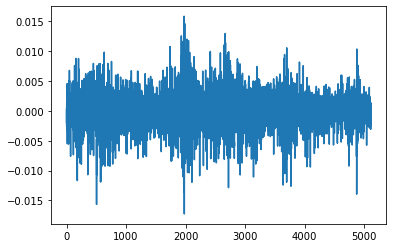

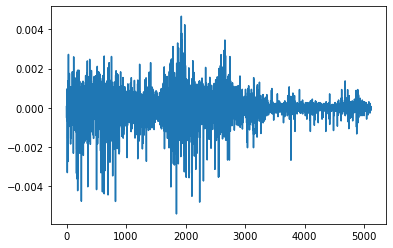

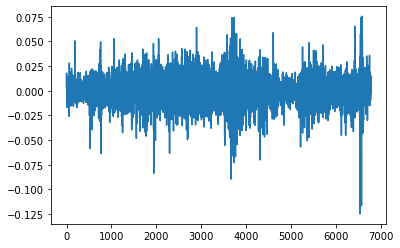

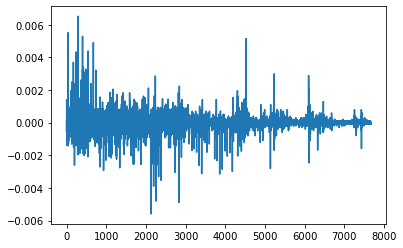

In [118]:
for future in utils.futuresList:
    pd.Series(transformations['linearize_detrend'](data[future]['CLOSE'])).plot()
    plt.show()

In [92]:
?KPSSTest

In [95]:
adf = KPSSTest(alpha=0.05)
adf.should_diff(y)

(0.1, False)

In [72]:
results.reset_index().groupby('future').max(['rsquared', 'pvalue']).transformation.unique()

array(['raw'], dtype=object)

In [ ]:
from pmdarima import AutoARIMA
from pmdarima.arima.utils import ndiffs, diff
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing.base import BaseTransformer

from sklearn.model_selection import GridSearchCV

class Linearize(BaseTransformer):
    def fit(self, y, exogenous):
        return self
    
    def transform(self, y, exogenous):
        return np.log(y)
    
class Detrend(BaseTransformer):
    def __init__(self, order=1):
        self.order = order
    
    def fit(self, y, exogenous):
        return self
    
    def transform(self, y, exogenous):
        return diff(y, difference=self.order)

Pipeline([
    ('linearize', Linearize()),
    ('detrend', Detrend()),
    ('arima', AutoARIMA(
        0, 0, 0,
        4, 0, 16,
        stationary=False, 
        seasonal=False,
    ))
])

param_grid = {
    'linearize': ['passthrough', Linearize()],
    'detrend': ['passthrough', Detrend(1), Detrend(2)],
}

In [109]:
?pm.auto_arima

In [99]:
pm.auto_arima(
    y, None,
    0, 1, 0,
    4, 2, 16,
    seasonal=False,
    information_criterion = 'aic',
    out_of_sample_size = 1,
    scoring = 'mse',
    trace = True,
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-90205.197, Time=2.73 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-92019.313, Time=6.95 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-93838.557, Time=7.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-90207.198, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-94120.301, Time=8.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-94292.959, Time=13.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-92748.357, Time=9.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-93806.562, Time=23.98 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-94708.623, Time=13.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-94515.423, Time=24.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-94647.643, Time=46.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-94810.030, Time=72.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-94879.121, Time=15.94 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-94941.342, Time=14.27 s

/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,5)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "statsmodels/tsa/statespace/_filters/_inversions.pyx", line 411, in statsmodels.tsa.statespace._filters._inversions.dinverse_univariate
ZeroDivisionError: float division

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/home/mitchellkwong/anaconda3/envs/BT4013/lib/python3.7/site-packages/pmdarima/arim

ARIMA(order=(0, 1, 5), out_of_sample_size=1, scoring_args={},
      suppress_warnings=True)